In [1]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
import numpy as np
from get_data import get_data
from sklearn.utils import shuffle
import torch.cuda
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os, sys
sys.path.append(os.pardir)
from mymodule.trainer import Trainer
from mymodule.utils import data_loader, evaluator
from tensorboardX import SummaryWriter
from mymodule.layers import BayesLSTM, Bayes_classifier
import time
%matplotlib inline

writer = SummaryWriter()
in_size = 28
hidden_size = 100
batch_size = 1024
linear_hidden_size = 512
epochs = 10
sample = 5
name = 'BayesLSTM'
'''
データの生成
'''
train, test, label = get_data(idx=2)
train = train.reshape(-1, 28, 28)
test = test.reshape(-1, 28, 28)
train_loader = data_loader(train, label, batch_size=batch_size,
                           shuffle=True, gpu=False)


class MLP(nn.Module):
  def __init__(self, in_size, hidden_size, batch_size,
               in_dropout, hidden_dropout, out_dropout,
               linear_in_size, linear_hidden_size, linear_out_size,
               linear_dropout, gpu=True):
    super(MLP, self).__init__()
    self.lstm = BayesLSTM(in_size=in_size,
                          hidden_size=hidden_size,
                          batch_size=batch_size,
                          in_dropout=in_dropout,
                          hidden_dropout=hidden_dropout,
                          out_dropout=out_dropout,
                          bias=True, gpu=gpu)
    self.l1 = nn.Linear(linear_in_size, linear_hidden_size)
    self.l2 = nn.Linear(linear_hidden_size, linear_out_size)
    self.linear_dropout = linear_dropout


  def forward(self, x):
    y_seq, _ = self.lstm(x)
    h = y_seq[:, -1, :]
    h = self.l1(h)
    h = F.dropout(h, p=self.linear_dropout, training=True)
    h = self.l2(h)
    return h

In [2]:
param = torch.load('BayesLSTM.pth')
model = MLP(in_size=in_size,
            hidden_size=hidden_size,
            batch_size=batch_size,
            in_dropout=0.4,
            hidden_dropout=0.4,
            out_dropout=0.4,
            linear_in_size=hidden_size,
            linear_hidden_size=linear_hidden_size,
            linear_out_size=2,
            linear_dropout=0.5,
            gpu=True)
model.cuda() #読み込む前にクラス宣言が必要
model.load_state_dict(param)
criterion = nn.CrossEntropyLoss()

In [19]:
class real_time_predictor(nn.Module):
    def __init__(self, model, in_dropout, hidden_dropout, out_dropout, linear_dropout, gpu=True):
        super(real_time_predictor, self).__init__()
        self.lstmcell = model.lstm.cell
        self.l1 = model.l1
        self.l2 = model.l2
        self.in_dropout = in_dropout
        self.hidden_dropout = hidden_dropout
        self.out_dropout = out_dropout
        self.linear_dropout = linear_dropout
        self.gpu = gpu

#     def drop_out(self):
#         self.in_drop_mask = Variable(
#             torch.bernoulli(
#             torch.ones(self.in_size) * (1 - self.in_dropout)))
#         self.hidden_drop_mask = Variable(
#             torch.bernoulli(
#             torch.ones(self.hidden_size) * (1 - self.hidden_dropout)))
#         self.out_drop_mask = Variable(
#             torch.bernoulli(
#             torch.ones(self.hidden_size) * (1 - self.out_dropout)))

#     if self.gpu:
#         self.in_drop_mask = self.in_drop_mask.cuda()
#         self.hidden_drop_mask = self.hidden_drop_mask.cuda()
#         self.out_drop_mask = self.out_drop_mask.cuda()

    def forward(self, x, h, c):
        x = F.dropout(x, self.in_dropout, training=True)
        h, c = self.lstmcell(x, (h, c))
        y = F.dropout(h, self.out_dropout, training=True)
        h = F.dropout(h, self.hidden_dropout, training=True)
        o1 = self.l1(y)
        o1 = F.dropout(o1, self.linear_dropout, training=True)
        o2 = self.l2(o1)
        return o2, h, c

predictor = real_time_predictor(model,
                                in_dropout=0.6,
                                hidden_dropout=0.6,
                                out_dropout=0.6,
                                linear_dropout=0.5)
test_real = test.reshape(-1, 28)
test_real = test_real[0::28]
test_real_var = Variable(torch.from_numpy(test_real).cuda())
predictor.cuda()

sample = 20
# predict = np.zeros((sample, len(test_real_var)))
predict = Variable(torch.zeros((sample, len(test_real_var))).cuda())

import time

h = Variable(torch.zeros((1, hidden_size)), volatile=True).cuda()
c = Variable(torch.zeros((1, hidden_size)), volatile=True).cuda()
start = time.time()
for i, x in enumerate(test_real_var):
    x = x.resize(1, 28)

#     o2, h, c = predictor(x, h, c) 
#     _, predict[0, i] = torch.max(o2, 1)

# 　時系列方向のドロップアウトと、初期状態維持が未完成
    for j in range(sample):
        o2, h, c = predictor(x, h, c) 
        _, predict[j, i] = torch.max(o2, 1)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:250.95679330825806[sec]


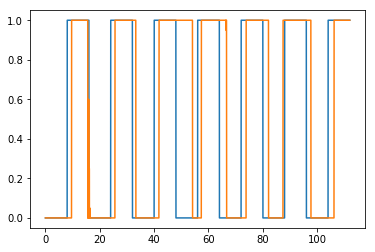

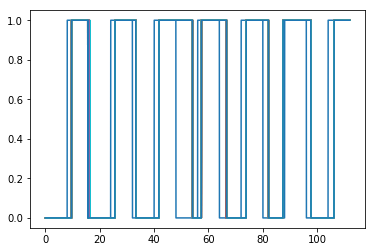

In [20]:
predict_numpy = predict.data.cpu().numpy()
all_predict = predict_numpy.T
mean_predict = predict_numpy.T.mean(axis=1)

plt.figure()
dt = 1/128
N = test.shape[0]
t = np.linspace(1, N, N) * dt - dt
plt.plot(t, label)
plt.plot(t,mean_predict)

plt.figure()
t = np.linspace(1, N, N) * dt - dt
plt.plot(t, label)
plt.plot(t,all_predict)

Test Accuracy of the model on 14336 test data:0.8643
elapsed_time:0.8289475440979004[sec]


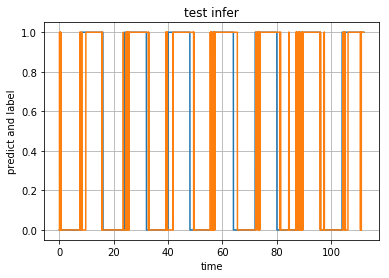

In [3]:
test_loader = data_loader(test, label, batch_size=1024,
                           shuffle=False, gpu=False)

bayes_predictor = Bayes_classifier(predictor=model, num_sample=1, num_class=2)
start = time.time()
loss, acc, pre_array = evaluator(bayes_predictor, criterion, test_loader)


elapsed_time = time.time() - start
print('Test Accuracy of the model on {} test data:{:0.4f}'.format(
      test.shape[0] , acc))
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

dt = 1/128
N = test.shape[0]
t = np.linspace(1, N, N) * dt - dt

plt.plot(t, label)
plt.plot(t, pre_array[:,1])
plt.grid()
plt.xlabel('time')
plt.ylabel('predict and label')
plt.title('test infer')
plt.show()

In [7]:
batch_size = 5
nb_digits = 2
# Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
y = torch.LongTensor(batch_size,1).random_().cuda() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits).long().cuda()

# In your for loop
y_onehot.zero_()
y_onehot.scatter_(1, y, 1)

print(y)
print(y_onehot)


 1
 0
 0
 1
 0
[torch.cuda.LongTensor of size 5x1 (GPU 0)]


 0  1
 1  0
 1  0
 0  1
 1  0
[torch.cuda.LongTensor of size 5x2 (GPU 0)]



In [21]:
label_onehot = torch.zeros(5, 2).long().cuda()

print(label_onehot)
# label_onehot.scatter_(1,torch.LongTensor([1,0,0,1,0]).cuda() ,1)
Variable(torch.LongTensor([1,0,0,1,0])).resize(5,1)


 0  0
 0  0
 0  0
 0  0
 0  0
[torch.cuda.LongTensor of size 5x2 (GPU 0)]



Variable containing:
 1
 0
 0
 1
 0
[torch.LongTensor of size 5x1]